In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle
import numpy as np
from tensorflow import keras
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.metrics import f1_score

In [31]:
def running_average(data, window_size):
    average_y = []
    for i in range(len(data) - window_size + 1):
        average_y.append(np.mean(data[i:i+window_size]))
    return average_y

def show_metric(selected_metric, average_window=0):
    # Liste zum Sammeln der Metrikwerte
    metric_values = []
    val_metric_values = []

    # Durchlaufe die Dateien und sammle die gewünschten Metriken
    for j in range(1, 6):
        for i in range(1, 6):
            file_path = f'FinalModel/history{j}.{i}.p'
            with open(file_path, 'rb') as file:
                history = pickle.load(file)
                metric_key = ['accuracy', 'loss', 'top_5_categorical_accuracy', 'top_10_categorical_accuracy'][selected_metric - 1]
                metric_values.extend(history[metric_key])
                val_metric_values.extend(history[f'val_{metric_key}'])


    # Plot der Metrikwerte und Running Average
    metric_name = ['accuracy', 'loss', 'top_5_categorical_accuracy', 'top_10_categorical_accuracy'][selected_metric - 1]
    plt.plot(metric_values, label=metric_name)
    plt.plot(val_metric_values, label='Validation ' + metric_name)
    if (average_window!=0):
        # Berechnung des Running Average für Trainings- und Validierungsdaten
        avg_metric_values = running_average(metric_values, average_window)
        avg_val_metric_values = running_average(val_metric_values, average_window)
        plt.plot(avg_metric_values, label='Running Average Training ' + metric_name, color='purple')
        plt.plot(avg_val_metric_values, label='Running Average Validation ' + metric_name, color='red')
    plt.title(f'Final Model Accuracy {metric_name}')
    plt.xlabel('Epochen')
    plt.ylabel(metric_name)
    plt.legend()
    plt.savefig(f'png/Finales Modell {metric_name}')

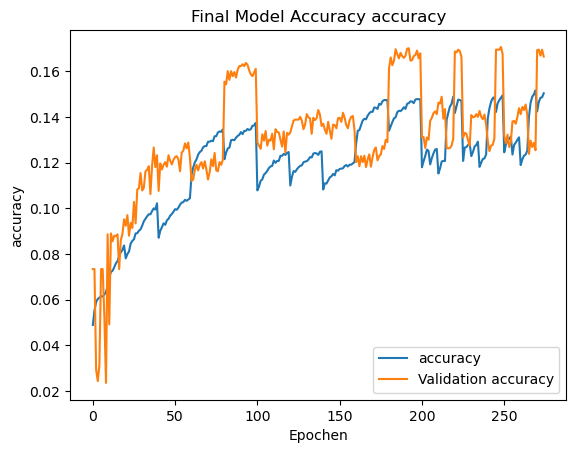

In [32]:
show_metric(1)

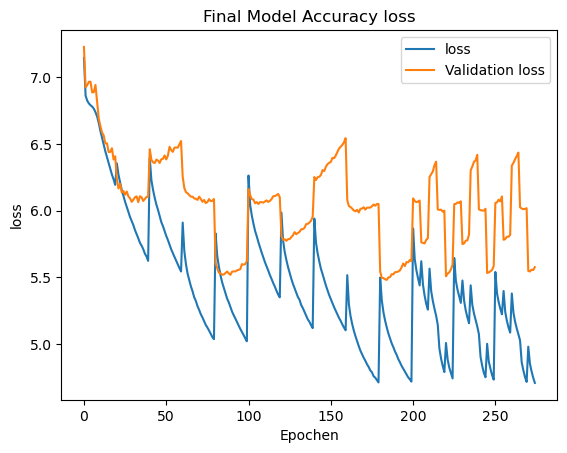

In [33]:
show_metric(2)

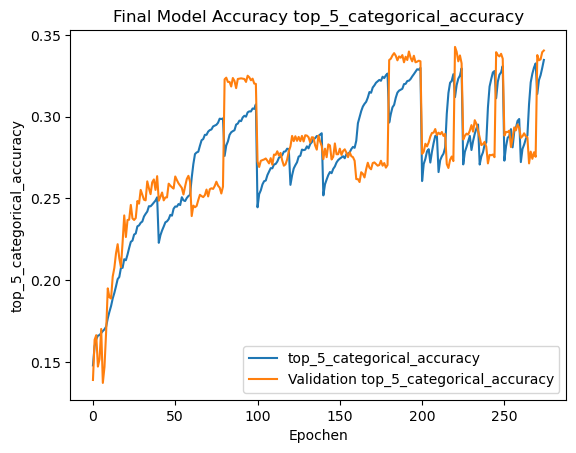

In [34]:
show_metric(3)

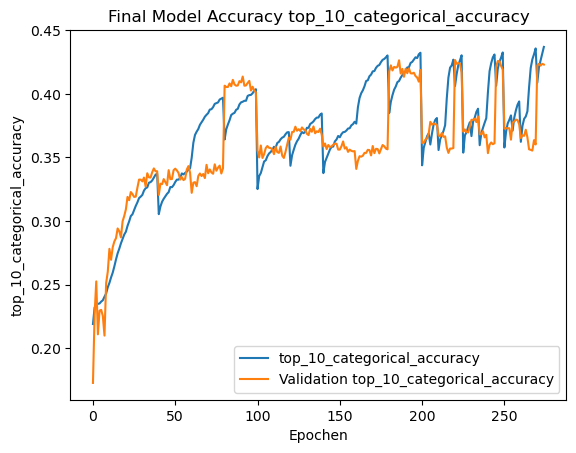

In [35]:
show_metric(4)

In [4]:
history = pickle.load(open("FinalModel/history5.5.p", "rb"))

print("FinalModel:")
print("Last accuracy:", history['accuracy'][-1])
print("Last val accuracy:", history['val_accuracy'][-1])
print("Last Loss:", history['loss'][-1])
print("Last val Loss:", history['val_loss'][-1])
print("Last top_5_categorical_accuracy:", history['top_5_categorical_accuracy'][-1])
print("Last val top_5_categorical_accuracy:", history['val_top_5_categorical_accuracy'][-1])
print("Last top_10_categorical_accuracy:", history['top_10_categorical_accuracy'][-1])
print("Last val top_10_categorical_accuracy:", history['val_top_10_categorical_accuracy'][-1])

FinalModel:
Last accuracy: 0.1503157913684845
Last val accuracy: 0.1664000004529953
Last Loss: 4.707952499389648
Last val Loss: 5.57696008682251
Last top_5_categorical_accuracy: 0.33464211225509644
Last val top_5_categorical_accuracy: 0.34040001034736633
Last top_10_categorical_accuracy: 0.43688422441482544
Last val top_10_categorical_accuracy: 0.4230000078678131


In [5]:
def load_data(number):
    folder_path = f'FormatedData/100000Packs/{number}/'
    
    with open(folder_path + 'x_val.pickle', 'rb') as file:
        x_val = pickle.load(file)
    with open(folder_path + 'y_val.pickle', 'rb') as file:
        y_val = pickle.load(file)
    
    return x_val, y_val
def combine_val_data(start_number, end_number):
    all_x_val = []
    all_y_val = []
    
    for number in range(start_number, end_number + 1):
        x_val, y_val = load_data(number)
        all_x_val.append(x_val)
        all_y_val.append(y_val)
    
    combined_x_val = np.concatenate(all_x_val, axis=0)
    combined_y_val = np.concatenate(all_y_val, axis=0)
    
    return combined_x_val, combined_y_val

In [6]:
# Vorbereiten der Validierungsdaten
x_val, y_val = combine_val_data(1,5)                     

In [13]:
# Metrics
def top_5_categorical_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)
def top_10_categorical_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)

# Registriere die benutzerdefinierten Metrikfunktionen
custom_objects = {'top_5_categorical_accuracy': top_5_categorical_accuracy,
                  'top_10_categorical_accuracy': top_10_categorical_accuracy}

# Lade das Modell mit den registrierten benutzerdefinierten Metriken
with tf.keras.utils.custom_object_scope(custom_objects):
    model = keras.models.load_model('FinalModel/Model5.5.h5')                             

# Vorhersagen des Modells für die Validierungsdaten
predictions = model.predict(x_val)
# Loss (Verlust)
model_data = model.evaluate(x_val, y_val)

print("Final Model:")
# Genauigkeit (Accuracy)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_val, axis=1))
print("Accuracy:", accuracy)

# Perplexität (Perplexity)
perplexity = np.exp(np.mean(-np.log(predictions[np.arange(len(y_val)), np.argmax(y_val, axis=1)])))
print("Perplexity:", perplexity)

# Top-k Genauigkeit (Top-k Accuracy)
k = 5  # Anzahl der wahrscheinlichsten Vorhersagen
top_k_accuracy = TopKCategoricalAccuracy(k=k)
top_k_accuracy.update_state(y_val, predictions)
print("Top-", k, "Accuracy:", top_k_accuracy.result().numpy())

# Top-k Genauigkeit (Top-k Accuracy)
k = 10  # Anzahl der wahrscheinlichsten Vorhersagen
top_k_accuracy = TopKCategoricalAccuracy(k=k)
top_k_accuracy.update_state(y_val, predictions)
print("Top-", k, "Accuracy:", top_k_accuracy.result().numpy())

print("loss,               accuracy ,          top_5,              top_10")
print(model_data)

782/782 [==============================] - 121s 154ms/step - loss: 6.2436 - accuracy: 0.1380 - top_5_categorical_accuracy: 0.2868 - top_10_categorical_accuracy: 0.3667
Final Model:
Accuracy: 0.138
Perplexity: 514.6904
Top- 5 Accuracy: 0.28684
Top- 10 Accuracy: 0.36672
loss,               accuracy ,          top_5,              top_10
[6.243565082550049, 0.1379999965429306, 0.2868399918079376, 0.3667199909687042]
